![Forecasting Demo 1: Baselines, Prophet, and NeuralProphet](https://raw.githubusercontent.com/VectorInstitute/forecasting-bootcamp/media-assets-do-not-merge/forecasting-demo-1.png?token=GHSAT0AAAAAABQMCWQFQHUMDN4MVB2LEQDUYQ7WXUQ)

This notebook is the first of a series that introduces the application of popular, recently developed time series forecasting methods. In particular, we emphasize the use of consistent evaluation metrics and analysis across all models and model configurations. 

Use these notebooks as tools to explore the application of various forecasting methods to multivariate time series datasets, and to inspire an experimental approach for comparing multiple models and model configurations.

This notebook explores the application of **Prophet** and **NeuralProphet** to exchange rate forecasting, as well as two baseline methods using **sktime**.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    !pip install sktime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet
from neuralprophet import NeuralProphet

# Data Loading

### Load exchange rate data file

The used dataset includes daily exchange rates between CAD and 12 other currencies between 2007 and 2017.

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# your Google Drive path may also begin with /content/drive/MyDrive/
data_filename = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/boc_exchange/dataset.csv"
data_df = pd.read_csv(data_filename, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df.reset_index().rename({'index':'date'}, axis=1)
data_df

,date,AUD_CLOSE,DKK_CLOSE,EUR_CLOSE,HKD_CLOSE,JPY_CLOSE,MXN_CLOSE,NZD_CLOSE,NOK_CLOSE,SEK_CLOSE,CHF_CLOSE,GBP_CLOSE,USD_CLOSE
0,2007-05-01,0.9200,0.2000,1.5100,0.141970,0.009271,0.10000,0.8200,0.1860,0.1700,0.9100,2.2199,1.1105
1,2007-05-02,0.9100,0.2000,1.5100,0.141740,0.009232,0.10000,0.8200,0.1854,0.1700,0.9100,2.2055,1.1087
2,2007-05-03,0.9100,0.2000,1.5000,0.141496,0.009190,0.10000,0.8100,0.1847,0.1600,0.9100,2.1999,1.1066
3,2007-05-04,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
4,2007-05-05,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,2017-04-24,1.0218,0.1974,1.4684,0.173684,0.012310,0.07215,0.9477,0.1579,0.1525,1.3568,1.7280,1.3511
3647,2017-04-25,1.0224,0.1994,1.4837,0.174374,0.012210,0.07183,0.9426,0.1586,0.1548,1.3661,1.7407,1.3565
3648,2017-04-26,1.0176,0.1995,1.4847,0.174965,0.012260,0.07098,0.9382,0.1585,0.1554,1.3707,1.7493,1.3612
3649,2017-04-27,1.0176,0.1992,1.4815,0.175103,0.012250,0.07151,0.9369,0.1590,0.1543,1.3704,1.7584,1.3624


### Split data according to use case

For simplicity, this notebook uses a conventional training and testing split over the dataset. Other notebooks will give examples of rolling cross validation using multiple validation periods given by a set of cutoff dates. 

The purpose of this notebook is to explore a simpler problem formulation using multiple models. The experiments and analysis can be easily adapted for rolling cross validation.

In [4]:
lag_time = 30
lead_time = 30

train_size = 0.8

train_df = data_df.iloc[:int(len(data_df)*train_size)]
test_df = data_df.iloc[int(len(data_df)*train_size):]

To ensure that we have enough data for testing, we need to withhold at least `lag_time + lead_time` observations from the dataset. Assuming we want to test a fitted model on all available examples in the test set, the number of testing examples can be computed as follows.

In [5]:
n_test_cases = len(test_df) - lag_time - lead_time + 1
print(f"   Timesteps in test_df: {len(test_df)}")
print(f"Number of test examples: {n_test_cases}")

   Timesteps in test_df: 731
Number of test examples: 672


### Iterating over test examples

To help with iterating over valid pairs of input and target data, we define a PyTorch-like dataset class. In this notebook, we'll use this primarily for iterating over test examples, since both Prophet and NeuralProphet impose their own, special formats for passing in training data.

In [6]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time + 1
        assert self.n_examples > 0, "Dataset must contain at least one example."
        assert "date" in data_df.columns or "ds" in data_df.columns, "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'date' in data_df.columns:
            self.dates = data_df.date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

Next, we instantiate an indexable `test_dataset`. 

In [7]:
feature_columns = [col for col in test_df if col.endswith("_CLOSE")]
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

# Evaluation Metrics

In order to objectively compare the performance of this and other models on out-of-sample forecasting performance, we will need to collect output in a consistent format and apply a suite of standard evaluation metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

See the article [Time Series Forecast Error Metrics You Should Know](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27) for an overview of these and other popular forecasting error metrics. 


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

In [9]:
def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

# Baseline Forecasts

Let's begin our experiments by producing forecasts using naïve estimators. A common baseline is *persistence forecasting*, where the forecast is simply an extension of the last known observation of the time series. A second baseline is the *mean window forecast*, where we take the mean over a window of observations and use this value for forecasts. The following code produces and collects the baseline forecasts into lists. 

In [10]:
baseline_model_persistence = NaiveForecaster(strategy='last')
baseline_model_mean = NaiveForecaster(strategy='mean',window_length=lag_time)

forecasts_persistence = []
forecasts_mean = []

for i in range(len(test_dataset)):
    x, y, x_d, y_d = test_dataset[i]
    
    persistence_fc = baseline_model_persistence.fit_predict(x['USD_CLOSE'], fh=list(range(lead_time)))
    persistence_fc = pd.Series(persistence_fc.values, index=y_d)
    forecasts_persistence.append(persistence_fc)

    mean_fc = baseline_model_mean.fit_predict(x['USD_CLOSE'], fh=list(range(lead_time)))
    mean_fc = pd.Series(mean_fc.values, index=y_d)
    forecasts_mean.append(mean_fc)

    print(i, end='\r')

### Compute error metrics over the baseline forecasts

In this notebook, we want to compare the performance of experimental models (Prophet, NeuralProphet) compared to baselines (persistence and mean window extension). The following code applies each of the four evaluation metrics for every example in the test set. 

In [11]:
def compute_baseline_error_metrics(forecasts, test_dataset):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        x, y, x_d, y_d = test_dataset[i]
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=y['USD_CLOSE'], y_pred=fc))

    return errors, forecasts

persistence_errors, _ = compute_baseline_error_metrics(forecasts_persistence, test_dataset)
mean_errors, _ = compute_baseline_error_metrics(forecasts_mean, test_dataset)

The following code uses the function `compute_error_statistics` to reduce the mean evaluation metrics over the entire test set to three statistics (mean, standard deviation, and max).

In [12]:
persistence_stats = compute_error_statistics(persistence_errors, 'persistence')
persistence_stats['mean']

mse     0.000544
rmse    0.020601
mae     0.017738
mape    0.013376
Name: persistence_mean_metrics, dtype: float64

In [13]:
mean_window_stats = compute_error_statistics(mean_errors, 'mean_window')
mean_window_stats['mean']

mse     0.000912
rmse    0.026212
mae     0.023677
mape    0.017827
Name: mean_window_mean_metrics, dtype: float64

We now collect the mean evaluation statistics for each metric into a DataFrame so that we can later compare these to experimental models.

In [14]:
results_df = pd.DataFrame(persistence_stats['mean']).T
results_df = results_df.append(mean_window_stats['mean'])
results_df

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827


### Visualizing forecasts over the test set

For each example in the test set, we have produced a forecast between `1` and `lead_time` days into the future. As we will see later, this is difficult to visualize over the whole test set. Instead, we can visualize the value of each forecast at a single time step into the future. The code below visualizes the baseline forecasts at the maximum lead time. As we can see, the persistence forecast is exactly the ground truth shifted `lead_time` days into the future. In the context of exchange rate forecasting, this baseline may be difficult to beat.

#### Persistence Forecasts At Max Lead Time

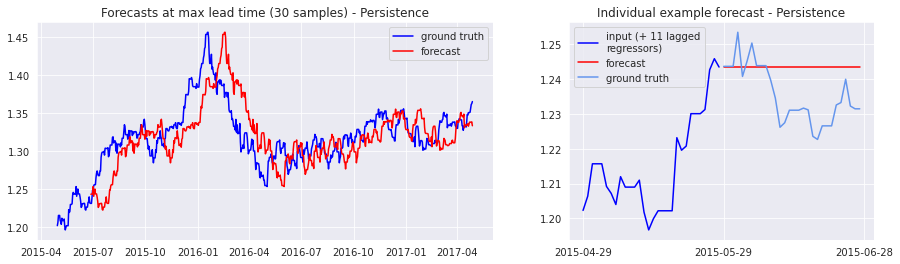

In [15]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts_persistence]
max_fcs = pd.DataFrame(max_fcs)

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
ax1.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
ax1.legend(loc='upper right')
start = 0
ax2.plot(test_df.date[start:start+30], test_df['USD_CLOSE'][start:start+30], color='blue', label='input (+ 11 lagged\nregressors)')
ax2.plot(test_df.date[start+30:start+60], [max_fcs.yhat[start]]*30, color='red', label='forecast')
ax2.plot(test_df.date[start+30:start+60], test_df['USD_CLOSE'][start+30:start+60], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - Persistence")
ax2.set_xticks(test_df.iloc[start:start+61:30].date)
ax2.legend(loc='upper left')
plt.show()

#### Mean Window Forecasts At Max Lead Time

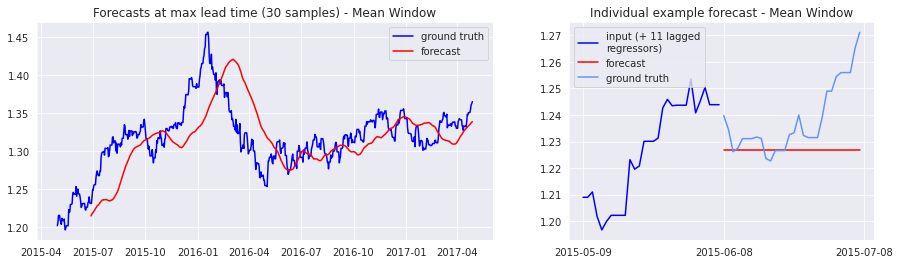

In [16]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts_mean]
max_fcs = pd.DataFrame(max_fcs)

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
ax1.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - Mean Window")
ax1.legend(loc='upper right')
start = 10
ax2.plot(test_df.date[start:start+30], test_df['USD_CLOSE'][start:start+30], color='blue', label='input (+ 11 lagged\nregressors)')
ax2.plot(test_df.date[start+30:start+60], [max_fcs.yhat[start]]*30, color='red', label='forecast')
ax2.plot(test_df.date[start+30:start+60], test_df['USD_CLOSE'][start+30:start+60], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - Mean Window")
ax2.set_xticks(test_df.iloc[start:start+61:30].date)
ax2.legend(loc='upper left')
plt.show()

# Prophet

Univariate forecasting that supports additional *future* regressors. Prophet does not support the inclusion of *lagged regressors*, i.e. it does not support the use of historical values of multiple series to predict a single target series. We include it as a baseline because it is popular, lightweight, interpretable, and performs very well in some domains. 

Prophet is based on a Generalized Additive Model (GAM):

$ y(t) = g(t) + s(t) + h(t) + \epsilon_t$

where $y(t)$ is the target series, $g(t)$ is the trend function, $s(t)$ is the seasonality or periodic function, $h(t)$ is a function reflecting holidays or other irregular events, and $\epsilon_t$ is an error term that is assumed to be normally distributed.

Despite being formulated as an additive model, multiplicative interaction between seasonality and trend components is supported (using a log transform). In the implementation, this is easily configurable using a constructor paramter. See the [documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for more details.

#### Data Preparation

Prophet, like most forecasting packages, imposes its own, specific format for input data. It expects inputs in the form of a Pandas DataFrame with two columns, `ds` and `y`, which correspond to Pandas-formatted timestamps and the target time series, respectively.

In this example, we create a Prophet DataFrame by selecting the columns `date` and `USD_CLOSE` from the Bank of Canada exchange rate dataset. We then rename those columns to `ds` and `y`, respectively. 

Note that the `ds` column is already correctly formatted using the Pandas datetime format, since we converted it immediately after loading the data. When reading CSVs, always be sure to check that datestamps are properly formatted.

In [17]:
prophet_model_df = train_df[['date', 'USD_CLOSE']]
prophet_model_df = train_df.rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1)
prophet_model_df = prophet_model_df[['ds', 'y']]
prophet_model_df

,ds,y
0,2007-05-01,1.1105
1,2007-05-02,1.1087
2,2007-05-03,1.1066
3,2007-05-04,1.1075
4,2007-05-05,1.1075
...,...,...
2915,2015-04-24,1.2170
2916,2015-04-25,1.2170
2917,2015-04-26,1.2170
2918,2015-04-27,1.2101


### Model Initialization and Fitting

For our baseline model, we fit Prophet using its default configuration.

In [18]:
model = Prophet()
model = model.fit(prophet_model_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.946
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9428.65      0.038986       7881.06           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9838.12     0.0035418       1408.13      0.9053      0.9053      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9933.1    0.00248332       1852.66           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10001.6     0.0151151       1265.49           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10067.2    0.00393545       843.215           1           1      572   
    Iter      log prob        ||dx||      ||grad||       alpha   

### Produce Forecasts

To produce a forecast using a fitted Prophet model, we need to pass it a dataframe with the desired timestamps in a column named `ds`. In the example below, we use the fitted model object to produce a dataframe `future` with dates that extend `len(test_df)` days beyond the training dates. Passing `future` to the fitted model's `predict` function will return a dataframe populated with a detailed forecast, including model component values and confidence ranges.

Notice here that we are asking Prophet to produce a single forecast for the entire test period. We are doing this because Prophet does not support inference using fixed-sized inputs in the same way that every other technique considered in our bootcamp does. 

In [19]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [20]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3646,2017-04-24,1.422472,0.499491,2.422587,0.493336,2.425515,0.001545,0.001545,0.001545,0.000002,0.000002,0.000002,0.001543,0.001543,0.001543,0.0,0.0,0.0,1.424017
3647,2017-04-25,1.422768,0.497492,2.425421,0.490243,2.427593,0.000608,0.000608,0.000608,-0.000072,-0.000072,-0.000072,0.000680,0.000680,0.000680,0.0,0.0,0.0,1.423376
3648,2017-04-26,1.423065,0.480820,2.430488,0.487198,2.429656,-0.000324,-0.000324,-0.000324,-0.000182,-0.000182,-0.000182,-0.000142,-0.000142,-0.000142,0.0,0.0,0.0,1.422740
3649,2017-04-27,1.423361,0.494653,2.422750,0.484526,2.431571,-0.001137,-0.001137,-0.001137,-0.000222,-0.000222,-0.000222,-0.000915,-0.000915,-0.000915,0.0,0.0,0.0,1.422224
3650,2017-04-28,1.423658,0.487542,2.426925,0.483044,2.433487,-0.001446,-0.001446,-0.001446,0.000188,0.000188,0.000188,-0.001634,-0.001634,-0.001634,0.0,0.0,0.0,1.422212


### Plotting Prophet Forecasts

The following code visualizes the application of the fitted Prophet model to both in-sample (training) and out-of-sample (testing) data. Visualization and evaluation of forecasting models using out-of-sample data is crucial for estimating future performance.

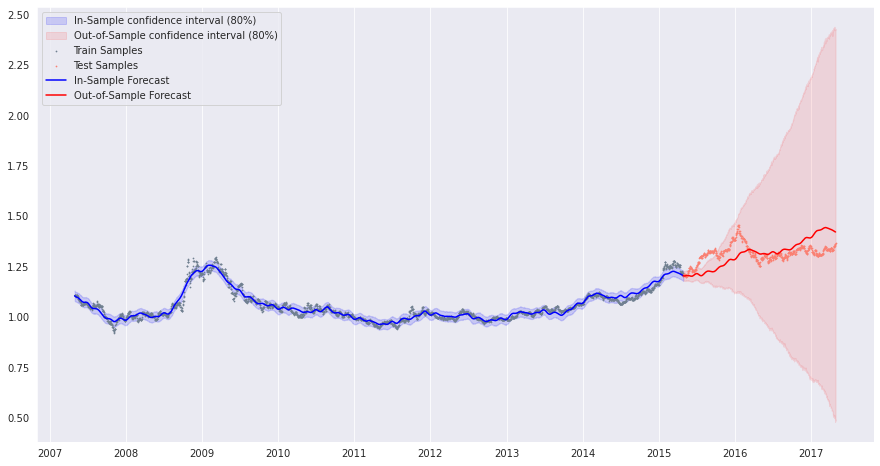

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.fill_between(forecast.ds.iloc[:-len(test_df)], 
    forecast.yhat_lower.iloc[:-len(test_df)], 
    forecast.yhat_upper.iloc[:-len(test_df)],
    color='blue', label='In-Sample confidence interval (80%)', alpha=0.15)

ax.fill_between(forecast.ds.iloc[-len(test_df):], 
    forecast.yhat_lower.iloc[-len(test_df):], 
    forecast.yhat_upper.iloc[-len(test_df):],
    color='red', label='Out-of-Sample confidence interval (80%)', alpha=0.1)

ax.scatter(prophet_model_df.ds, prophet_model_df['y'], color='slategrey', s=3, linewidths=0, label='Train Samples')
ax.scatter(test_df.date, test_df['USD_CLOSE'], color='salmon', s=3, linewidths=0, label='Test Samples')

ax.plot(forecast.ds.iloc[:-len(test_df)], 
        forecast.yhat.iloc[:-len(test_df)], color='blue', label='In-Sample Forecast')

ax.plot(forecast.ds.iloc[-len(test_df):], forecast.yhat.iloc[-len(test_df):], 
        color='red', label='Out-of-Sample Forecast')

ax.legend(loc='upper left')
ax.grid(axis='y')
plt.show()

### Prophet Forecasts At Max Lead Time

As we did with the baseline methods, let's visualize Prophet's forecasts at maximum lead time. 

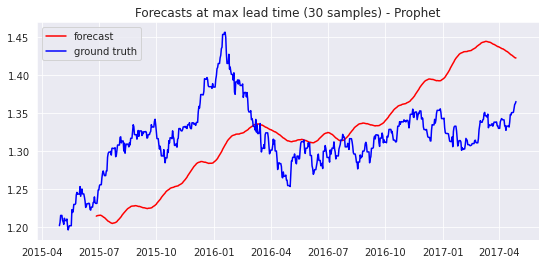

In [22]:
# We can use our ForecastingDataset class to help with formatting Prophet's output.
forecast_eval_dataset = ForecastingDataset(forecast.iloc[-len(test_df):], lag_time, lead_time, ['yhat'])

fig, ax = plt.subplots(figsize=(9,4))

forecasts_at_max_lead = []
dates_at_max_lead = []

for i in range(len(forecast_eval_dataset)):
    x, y, x_d, y_d = forecast_eval_dataset[i]
    x_gt, y_gt, x_gt_d, y_gt_d = test_dataset[i]

    forecasts_at_max_lead.append(y.values[-1])
    dates_at_max_lead.append(y_d.values[-1])

ax.plot(dates_at_max_lead, forecasts_at_max_lead, color='red', label='forecast')
ax.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
plt.legend()
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Prophet")
plt.show()

With the help of the ForecastingDataset class defined earlier, iterate over each forecast and ground truth pair, and compute and collect multiple evaluation metrics as defined in the previous cell.

In [23]:
def compute_error_metrics(ground_truth_dataset, forecast_dataset):
        
    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecast_dataset)):
        x, y, x_d, y_d = forecast_dataset[i]
        x_gt, y_gt, x_gt_d, y_gt_d = ground_truth_dataset[i]
        for metric_name, metric_fn in metrics.items(): 
            errors[metric_name].append(metric_fn(y_true=y_gt['USD_CLOSE'], y_pred=y))
    
    return errors

error_metrics = compute_error_metrics(test_dataset, forecast_eval_dataset)

In [24]:
prophet_stats = compute_error_statistics(error_metrics, 'prophet')
prophet_stats['mean']

mse     0.004840
rmse    0.061076
mae     0.059036
mape    0.044389
Name: prophet_mean_metrics, dtype: float64

Let's now collect the mean evaluation metrics into a new DataFrame that we will use for comparative evalution against other models' forecasts.

Please note that the comparison is not completely fair - Prophet has to predict 672 steps into the future at once, whereas our baselines only have to predict the next 30 days.

In [25]:
results_df = results_df.append(prophet_stats['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389


# NeuralProphet

Let's proceed to explore the [NeuralProphet](https://neuralprophet.com/html/index.html) model. Please review the following resources to learn more:

- [Paper](https://arxiv.org/abs/2111.15397)
- [Documentation](https://neuralprophet.com/html/contents.html)
- [GitHub](https://github.com/ourownstory/neural_prophet)

In the words of its developers, NeuralProphet is "*based on neural networks, inspired by Facebook Prophet and AR-Net, built on PyTorch*". A very important differentiating feature is that NeuralProphet conveniently supports *lagged regressors*. In the context of this running example, NeuralProphet supports the use of multiple other currencies' time series. With this expanded flexibility, however, the model is more complex, with a greater number of design choices and hyperparameters to consider. 

The official [documentation on lagged regressors (lagged covariates)](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html) gives several examples for configuring NeuralProphet models to use lagged regressors, but commentary and suggestions on best practices are largely absent. 

In the following code, we will consider a small number of NeuralProphet model configurations applied to the same forecasting task from above. Importantly, we retain the same train/test (in-sample/out-of-sample) split, and we will apply the same evaluation metrics to NeuralProphet's forecasts. 

### Data Formatting

NeuralProphet's data format is very similar to Prophet's. We prepare new DataFrames for training and evaluation.

In [26]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

Of course the most important difference between the DataFrames prepared for Prophet and NeuralProphet is that, with NeuralProphet, we have the opportunity to include data about the non-target variables as lagged regressors.

In [27]:
np_train_df.head(5)

,ds,AUD_CLOSE,DKK_CLOSE,EUR_CLOSE,HKD_CLOSE,JPY_CLOSE,MXN_CLOSE,NZD_CLOSE,NOK_CLOSE,SEK_CLOSE,CHF_CLOSE,GBP_CLOSE,y
0,2007-05-01,0.92,0.2,1.51,0.141970,0.009271,0.1,0.82,0.1860,0.17,0.91,2.2199,1.1105
1,2007-05-02,0.91,0.2,1.51,0.141740,0.009232,0.1,0.82,0.1854,0.17,0.91,2.2055,1.1087
2,2007-05-03,0.91,0.2,1.50,0.141496,0.009190,0.1,0.81,0.1847,0.16,0.91,2.1999,1.1066
3,2007-05-04,0.91,0.2,1.51,0.141616,0.009218,0.1,0.81,0.1854,0.16,0.91,2.2075,1.1075
4,2007-05-05,0.91,0.2,1.51,0.141616,0.009218,0.1,0.81,0.1854,0.16,0.91,2.2075,1.1075


## Baseline/Default Model

A baseline NeuralProphet model with lagged regressors using default initialization parameters, except:

- `n_lags=lag_time`, specifying that the autoregressive component of the model should use the past `lag_time` daily observations as inputs
- `n_forecasts=lead_time`, specifying that our use case is to predict the target signal `lead_time` days into the future

NeuralProphet also allows you to specify a `validation_df` in `fit()`, on which the model will be evaluated every epoch. We are not using this feature here.

In [28]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.95E-04, min: 6.48E-02
INFO:NP.utils_torch:lr-range-test results: steep: 8.95E-04, min: 6.48E-02


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.67E-04, min: 6.01E-02
INFO:NP.utils_torch:lr-range-test results: steep: 9.67E-04, min: 6.01E-02


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.06E-03, min: 8.16E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.06E-03, min: 8.16E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.83E-03
INFO:NP.forecaster:lr-range-test selected learning rate: 1.83E-03
Epoch[138/138]: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s, SmoothL1Loss=0.00361, MAE=0.0203, RMSE=0.0271, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.945209,0.769462,0.995288,0.0
1,1.740009,0.701598,0.920175,0.0
2,1.503965,0.623280,0.828849,0.0
3,1.237858,0.534686,0.717894,0.0
4,0.982378,0.449213,0.599998,0.0
...,...,...,...,...
133,0.003624,0.020287,0.027148,0.0
134,0.003619,0.020275,0.027144,0.0
135,0.003617,0.020267,0.027149,0.0
136,0.003614,0.020258,0.027133,0.0


After fitting, you can plot the learned model parameters, including the additional 30 lagged regressors.

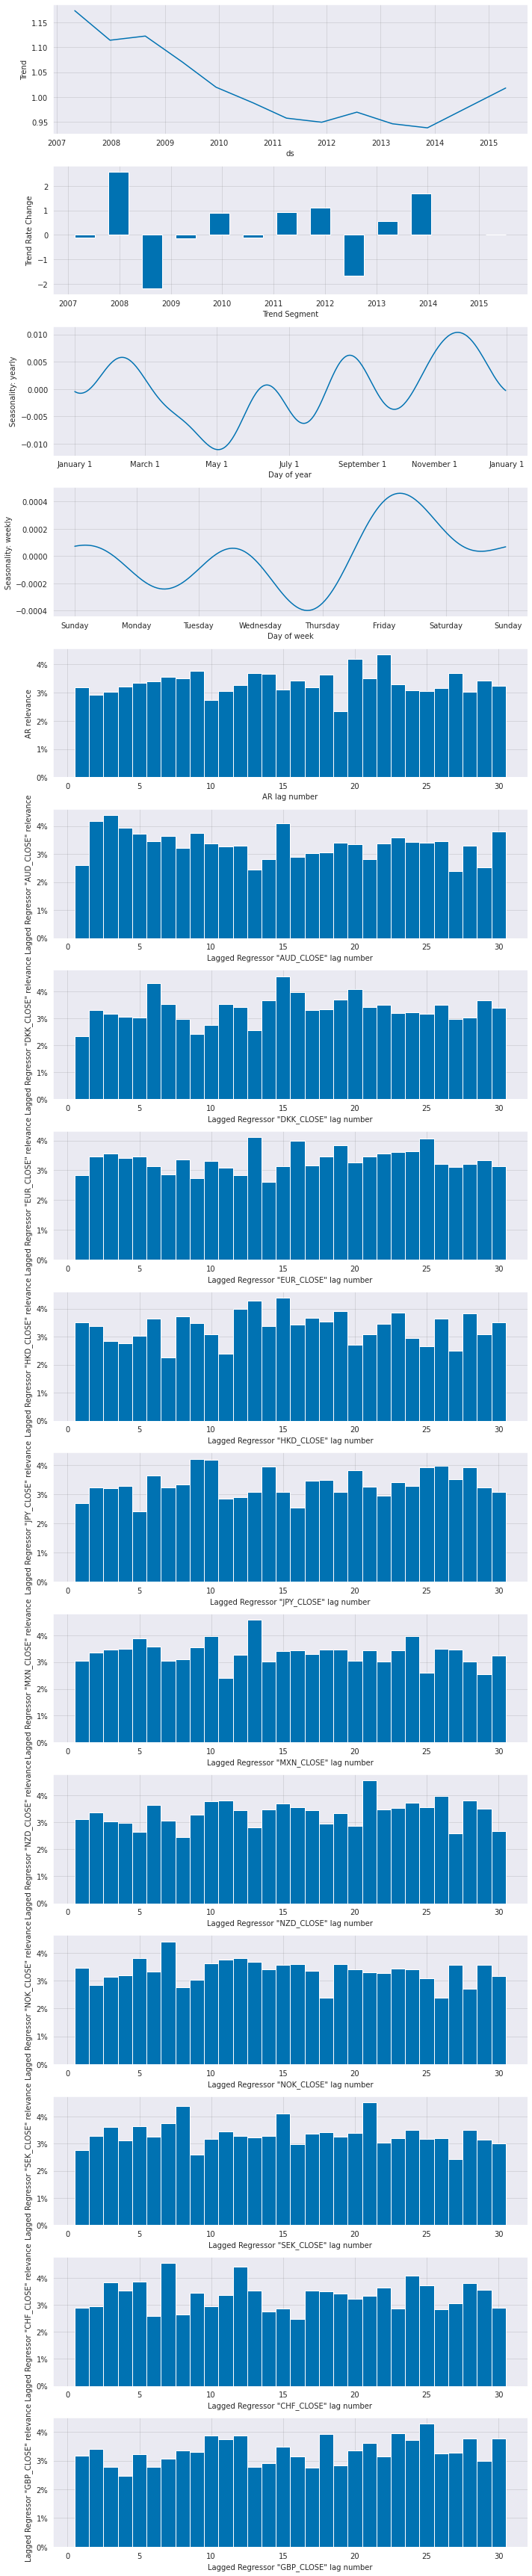

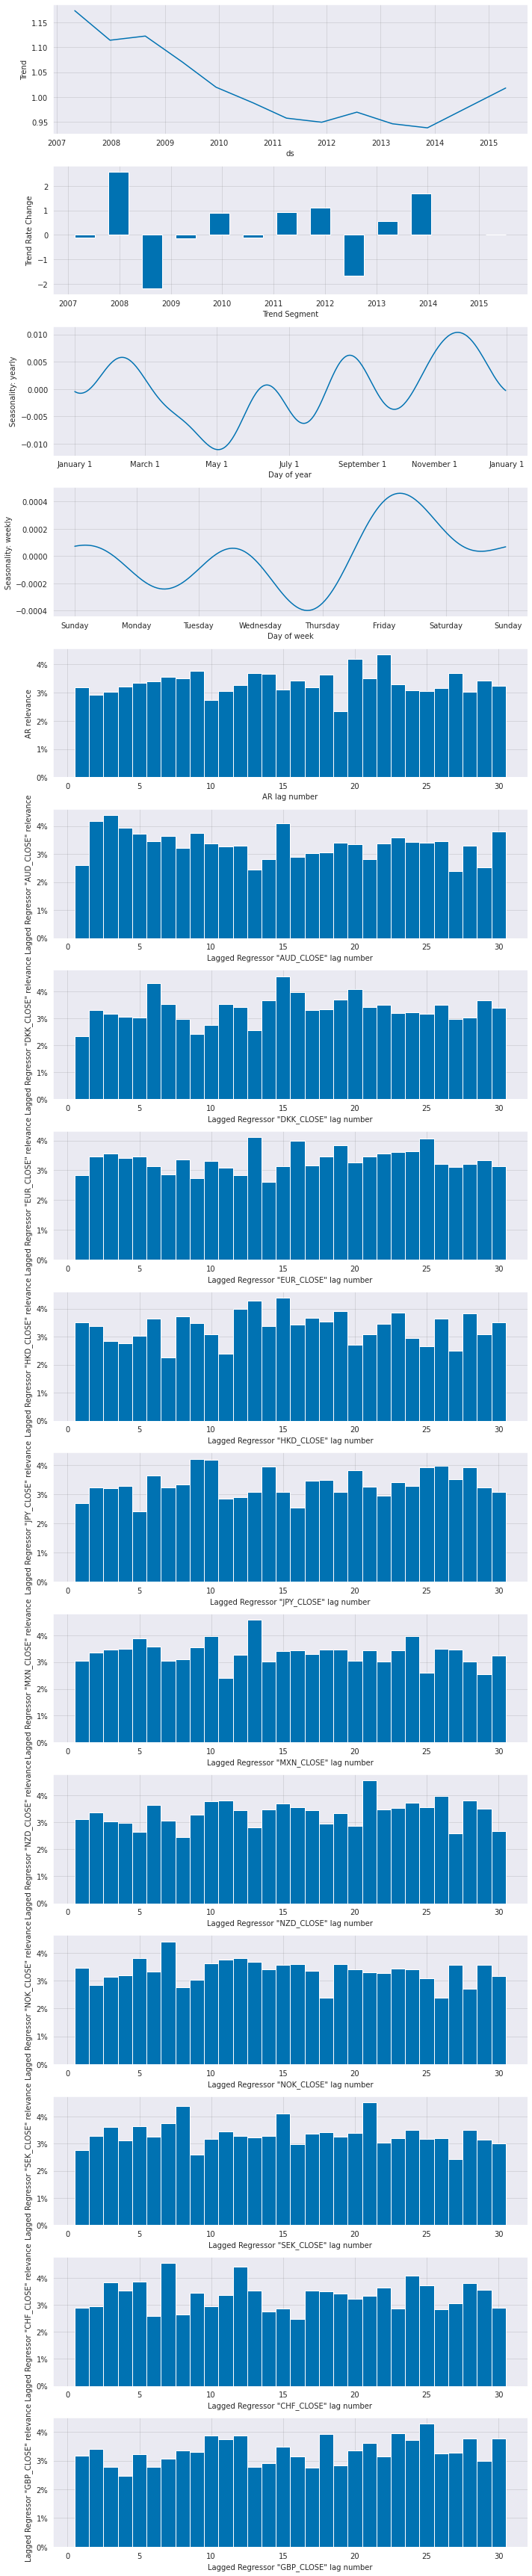

In [29]:
np_model.plot_parameters()

NeuralProphet, rather annoyingly, does not collect forecasts into a single yhat variable, but rather into separate `stepX`s for each of the lead times. For example, the following is a single 30-day forecast:

In [30]:
x, y, x_d, y_d = test_dataset[0]
x = x.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
y = y.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

np_future_df = np_model.make_future_dataframe(x, periods=len(y))
np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
np_forecast

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6,step7,step8,...,step20,step21,step22,step23,step24,step25,step26,step27,step28,step29
0,2015-05-29,1.313881,1.281444,1.317688,1.263233,1.275852,1.246776,1.259627,1.300999,1.258939,...,1.285243,1.239364,1.269347,1.244313,1.284972,1.20531,1.253115,1.235517,1.270402,1.264408


To get a more useable data structure, the following function takes a NeuralProphet forecast dataframe and turns it into a time series of its predictions:

In [31]:
def yhat_from_neuralprophet_forecast(np_forecast, y_d):
    return pd.Series(np_forecast.T.iloc[1:].set_index(y_d).iloc[:,0], name='np_yhat').rename_axis('ds')

The forecast from above would now look this:

In [32]:
yhat_from_neuralprophet_forecast(np_forecast, y_d)

ds
2015-05-29    1.313881
2015-05-30    1.281444
2015-05-31    1.317688
2015-06-01    1.263233
2015-06-02    1.275852
2015-06-03    1.246776
2015-06-04    1.259627
2015-06-05    1.300999
2015-06-06    1.258939
2015-06-07    1.249817
2015-06-08    1.278792
2015-06-09    1.282247
2015-06-10    1.269285
2015-06-11    1.266546
2015-06-12    1.301882
2015-06-13    1.242995
2015-06-14    1.250111
2015-06-15    1.276292
2015-06-16     1.24294
2015-06-17     1.30375
2015-06-18    1.285243
2015-06-19    1.239364
2015-06-20    1.269347
2015-06-21    1.244313
2015-06-22    1.284972
2015-06-23     1.20531
2015-06-24    1.253115
2015-06-25    1.235517
2015-06-26    1.270402
2015-06-27    1.264408
Name: np_yhat, dtype: object

Since NeuralProphet uses a fixed-size input sequence (lagged observations) to produce forecasts, we iterate over the input sequences in the test set and use them as model inputs to produce forecasts. This mode of inference should be more familiar to machine learning practitioners than Prophet's. Note that NeuralProphet requires us to first format input data using the `make_future_dataframe` function before running inference using the `predict` function. We define the following function, which produces forecasts for each of the input/ground-truth-output sequences in the test set.

In [33]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
        fc_series = yhat_from_neuralprophet_forecast(np_forecast, y_d)
        forecasts.append(fc_series)

    return forecasts

Similarly to what we defined for Prophet, we define the following function for computing and collecting evaluation metrics over all of the forecasts.

In [34]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.date.isin(fc.index)].sort_values('date')  # Sorting because I am not 100% sure that the 'isin' function always preserves order.
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['USD_CLOSE'], y_pred=fc))

    return errors, forecasts

In [35]:
forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

### Plot all forecasts

We have the option to visualize complete forecasts at every time step, but it does not tell us much about the model's performance.

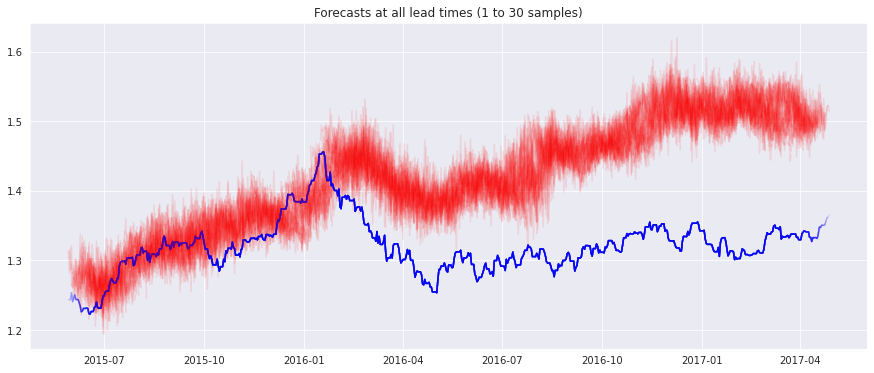

In [36]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[:], fc[:], alpha=0.1, color='red')
    ax.plot(gt.date, gt['USD_CLOSE'], alpha=0.1, color='blue')
plt.title(f"Forecasts at all lead times (1 to {lead_time} samples)")
plt.show()

### Plot all forecasts at max lead time

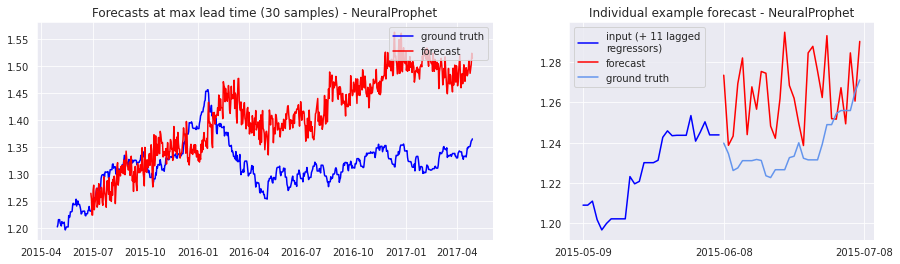

In [37]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
ax1.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - NeuralProphet")
ax1.legend(loc='upper right')
start = 10
ax2.plot(test_df.date[start:start+30], test_df['USD_CLOSE'][start:start+30], color='blue', label='input (+ 11 lagged\nregressors)')
ax2.plot(test_df.date[start+30:start+60], max_fcs.yhat[start:start+30], color='red', label='forecast')
ax2.plot(test_df.date[start+30:start+60], test_df['USD_CLOSE'][start+30:start+60], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - NeuralProphet")
ax2.set_xticks(test_df.iloc[start:start+61:30].date)
ax2.legend(loc='upper left')
plt.show()

### Append evaluation metrics to `results_df`

In [38]:
results_df = results_df.append(compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


## Restricted model

The baseline NeuralProphet model does not perform well on out-of-sample data. We can consider multiple changes to the model's configuration and hyperparameters in pursuit of better performance. Let's consider the following configuration that restricts the model to using only the last observed value of last regressors, as opposed to `n_lags` past observations. While less expressive, this model may be less prone to overfitting.

In [39]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}', only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.40E-02, min: 7.49E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.40E-02, min: 7.49E-01


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.40E-02, min: 7.49E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.40E-02, min: 7.49E-01


  0%|          | 0/272 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.40E-02, min: 7.49E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.40E-02, min: 7.49E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.40E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.40E-02
Epoch[138/138]: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s, SmoothL1Loss=0.00175, MAE=0.0134, RMSE=0.0187, RegLoss=0]
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNI

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

Once again, we are able to plot the learned parameters of the model. The lagged regressors are now grouped together in a single chart, as only one value of each is used.

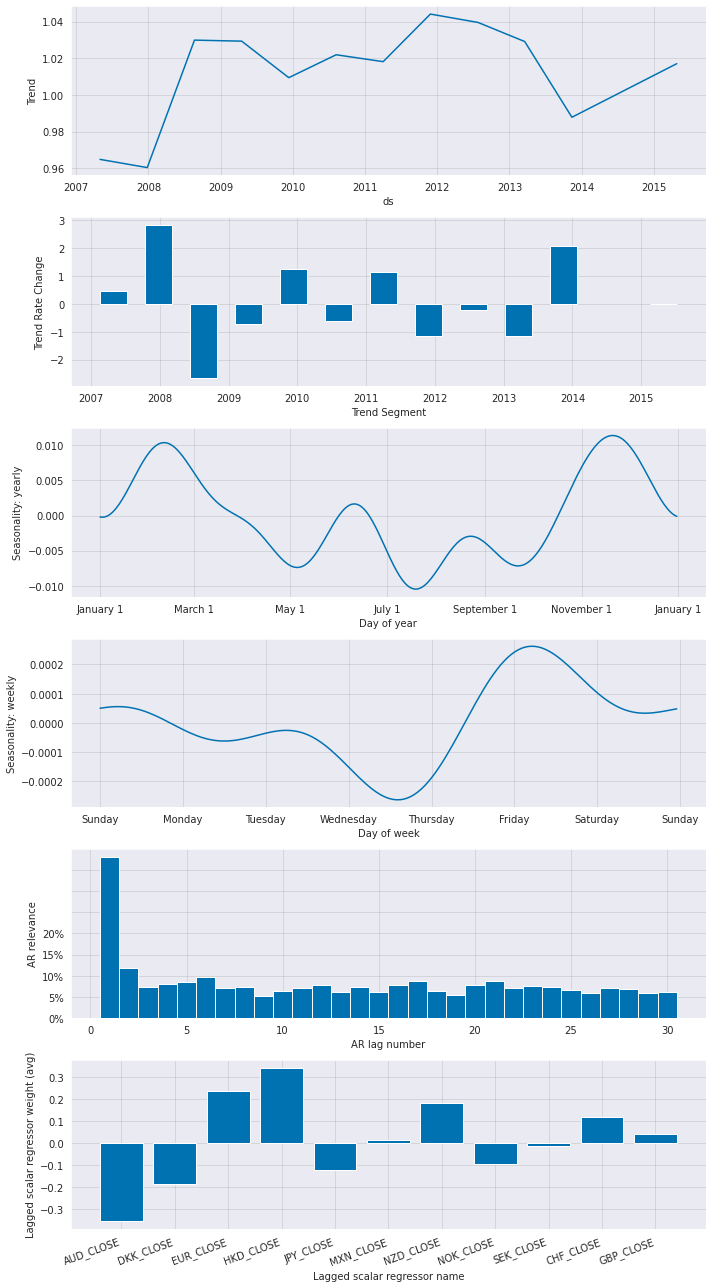

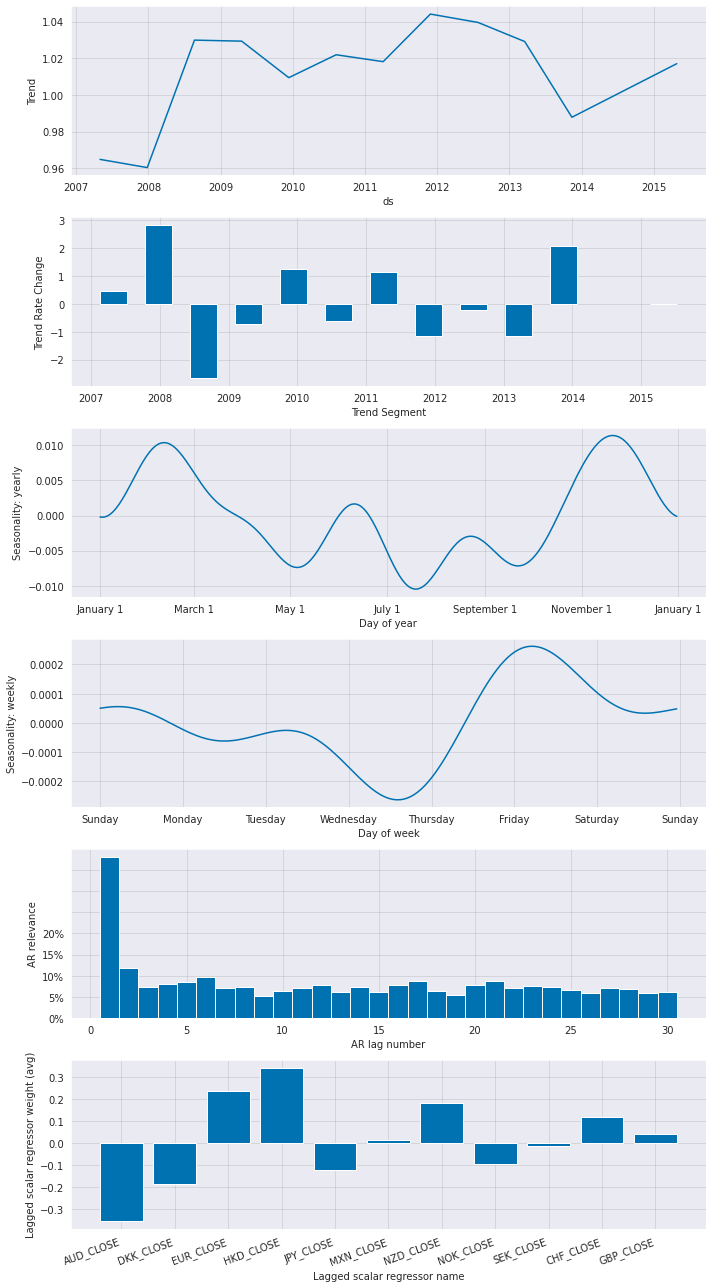

In [40]:
np_model_last_sample_only.plot_parameters()

### Plot forecasts at max lead time

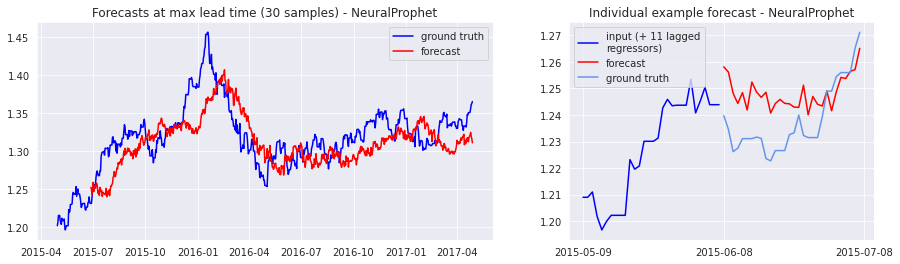

In [41]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
ax1.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - NeuralProphet")
ax1.legend(loc='upper right')
start = 10
ax2.plot(test_df.date[start:start+30], test_df['USD_CLOSE'][start:start+30], color='blue', label='input (+ 11 lagged\nregressors)')
ax2.plot(test_df.date[start+30:start+60], max_fcs.yhat[start:start+30], color='red', label='forecast')
ax2.plot(test_df.date[start+30:start+60], test_df['USD_CLOSE'][start+30:start+60], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - NeuralProphet")
ax2.set_xticks(test_df.iloc[start:start+61:30].date)
ax2.legend(loc='upper left')
plt.show()

### Append evaluation metrics to `results_df`

In [42]:
results_df = results_df.append(compute_error_statistics(np_last_sample_only_error_metrics, 'neural_prophet_last_sample_only')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
neural_prophet_last_sample_only_mean_metrics,0.000619,0.022734,0.019712,0.014834
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


## Model with Sparse Neural Autoregression

In the previous parameter plots, you could see high values for all autoregressive features. You can tell NeuralProphet to try avoiding relying on them too much by restricting how many of them it is able to use. In this case, we set `ar_sparsity` to 0.1, meaning the least informative 90% of AR coefficients will not be included in the model. But: NeuralProphet applies this sparsity factor only to the regular AR coefficients, not the lagged regressor AR coefficients, where higher sparsity would make more sense.

We can also play around with parameters like the number of hidden layers or the learning rate of the AR-Net. Another change applied to this model is the loss function, now MAE instead of the default Huber loss.

In [43]:
np_model_sparse_nar = NeuralProphet(n_lags=lag_time, 
                                    n_forecasts=lead_time,
                                    ar_sparsity=0.1,
                                    learning_rate=5e-3,
                                    num_hidden_layers=2,
                                    d_hidden=16,
                                    loss_func='MAE'
                                    )

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_sparse_nar.add_lagged_regressor(f'{feature}')
    
np_model_sparse_nar.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_sparse_nar, test_dataset)
np_sparse_ar_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138
Epoch[138/138]: 100%|██████████| 138/138 [02:43<00:00,  1.19s/it, L1Loss=0.0271, MAE=0.00869, RMSE=0.0129, RegLoss=0.00298]
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are inc

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

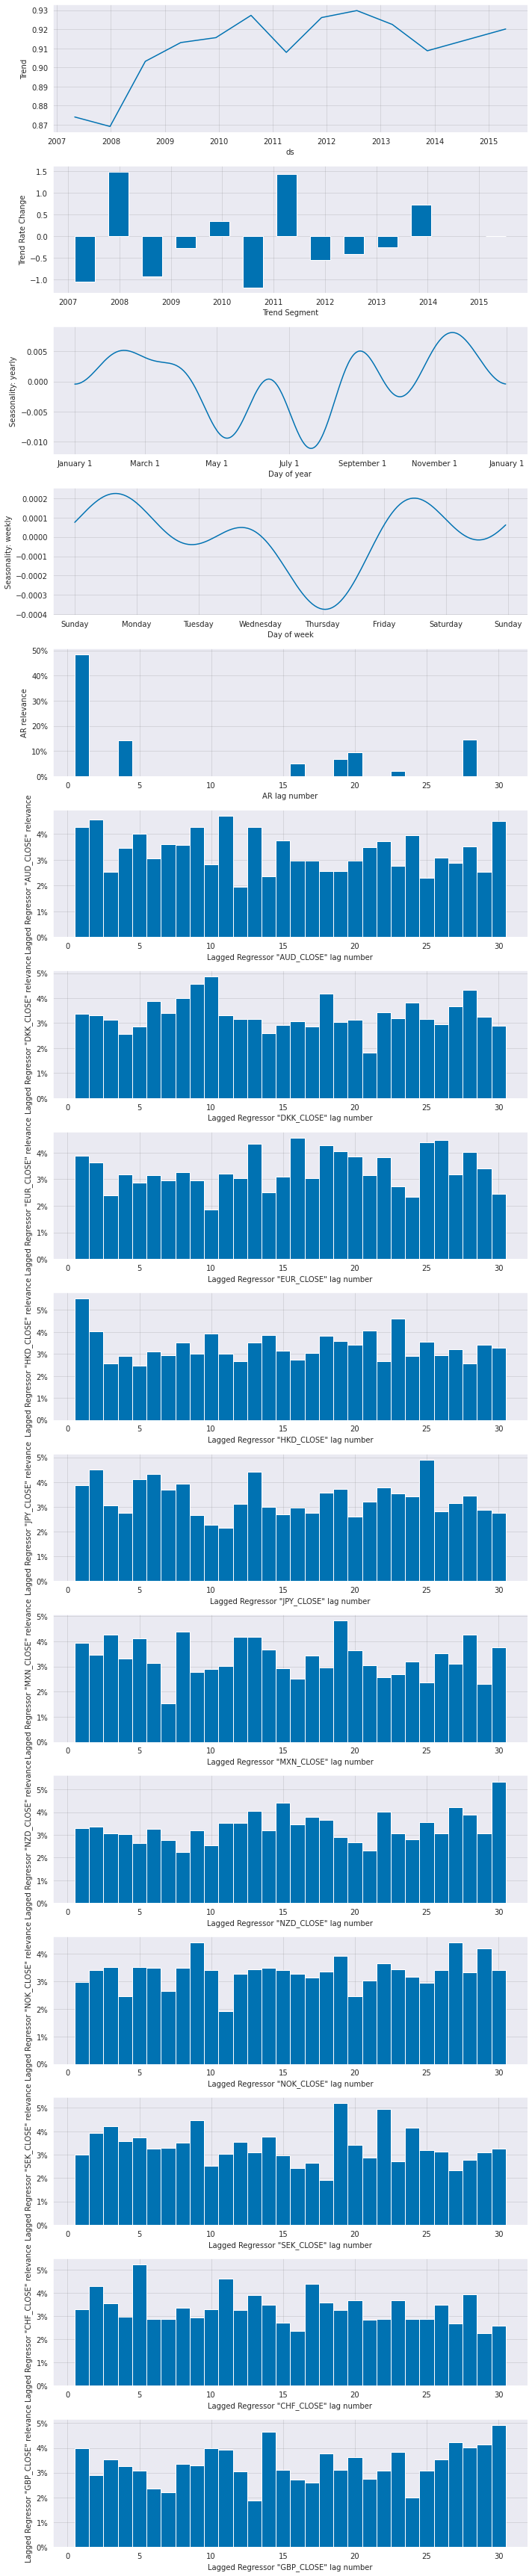

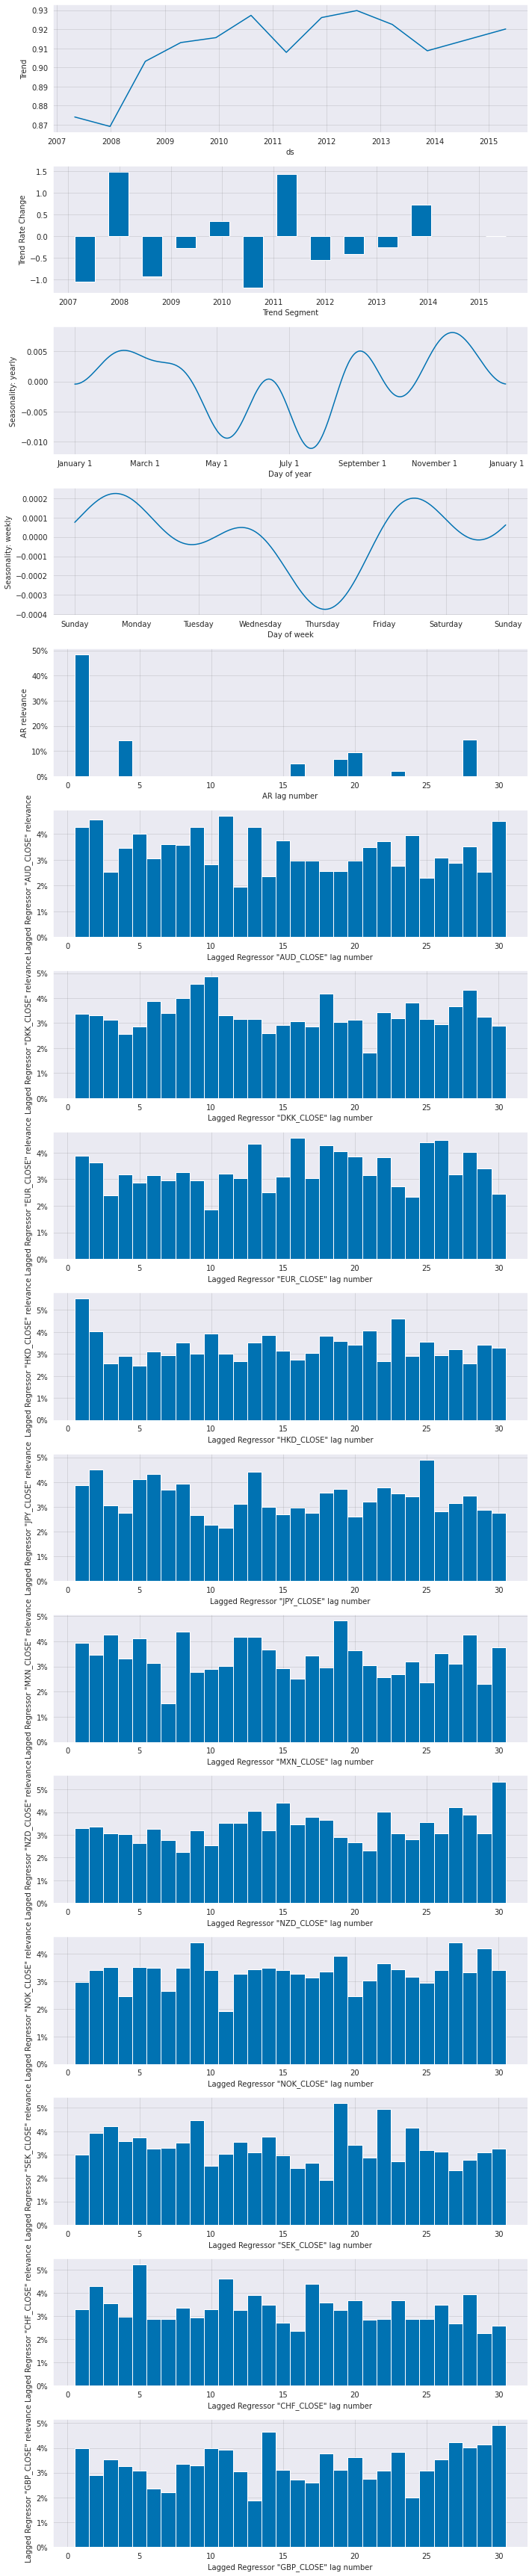

In [44]:
np_model_sparse_nar.plot_parameters()

### Plot forecasts at max lead time

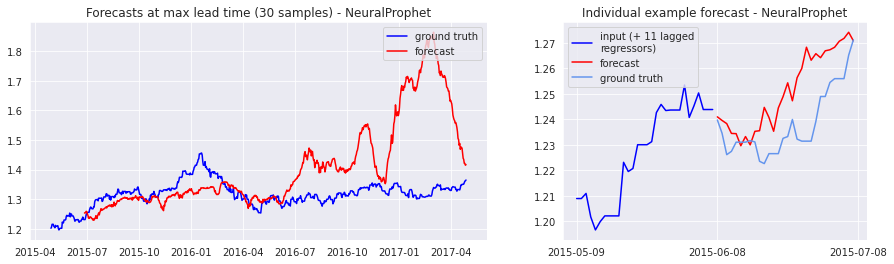

In [45]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
ax1.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - NeuralProphet")
ax1.legend(loc='upper right')
start = 10
ax2.plot(test_df.date[start:start+30], test_df['USD_CLOSE'][start:start+30], color='blue', label='input (+ 11 lagged\nregressors)')
ax2.plot(test_df.date[start+30:start+60], max_fcs.yhat[start:start+30], color='red', label='forecast')
ax2.plot(test_df.date[start+30:start+60], test_df['USD_CLOSE'][start+30:start+60], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - NeuralProphet")
ax2.set_xticks(test_df.iloc[start:start+61:30].date)
ax2.legend(loc='upper left')
plt.show()

### Append evaluation metrics to `results_df`

In [46]:
results_df = results_df.append(compute_error_statistics(np_sparse_ar_error_metrics, 'neural_prophet_sparse_ar')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
neural_prophet_last_sample_only_mean_metrics,0.000619,0.022734,0.019712,0.014834
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
neural_prophet_sparse_ar_mean_metrics,0.007931,0.064557,0.050069,0.037748
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


# Reflections and Next Steps

So far, the best performing 'model' is the persistence forecasting model. This is, of course, an unsatisfactory result. The best performing experimental model on the exchange rates dataset is the restricted NeuralProphet model that uses only the last observation of lagged regressors as features. Of course, we have only considered a very small number of comfigurations using NeuralProphet, many more model and hyperparameter configurations are possible. Please refer to the [NeuralProphet documentation](https://neuralprophet.com/html/contents.html) for detailed information. However, to *find* a better configuration may require significant effort, either manual or automated (via a hyperparameter search, for example). In practical forecasting use cases, it may be important to consider the time, resources, and effort that are needed to find a forecasting model that is better than  baseline.

The following notebooks in this series will cover additional models (N-BEATS and DeepAR) as well as rolling cross validation using NeuralProphet. In order to compare the out-of-sample forecasts produced by this notebook to others, the `results_df` DataFrame is saved below. Hopefully we will find a model that performs better than baseline in a continued out-of-sample evaluation experiment!

In [48]:
output_filename = "/h/kkoch/forecasting-bootcamp/demos/exchange_rate_mean_test_metrics.csv"
results_df.to_csv(output_filename)